## ✒️ Code Modules

In [7]:
from IPython.display import display,HTML
from IPython.core.magic import register_line_magic
import tensorflow as tf,tensorflow_hub as hub,numpy as np
import os,h5py,urllib,pandas as pd,pylab as pl
file_path='https://raw.githubusercontent.com/'+\
           'OlgaBelitskaya/data_kitchen/main/'
file_name='HorseBreeds160.h5'
img_size=int(128)

## ✒️  Image Data

In [2]:
def get_data(file_path,file_name,img_size=int(160)):
    input_file=urllib.request.urlopen(file_path+file_name)
    output_file=open(file_name,'wb')
    output_file.write(input_file.read())
    output_file.close(); input_file.close()
    with h5py.File(file_name,'r') as f:
        keys=list(f.keys())
        print('file keys: '+', '.join(keys))
        images=np.array(f[keys[0]])
        images=tf.image.resize(images,[img_size,img_size]).numpy()
        labels=np.array(f[keys[1]])
        names=[el.decode('utf-8')for el in f[keys[2]]]
        f.close()
    return images,labels,names
images,labels,names=get_data(file_path,file_name,img_size)

file keys: images, labels, names


## ✒️ Data Processing

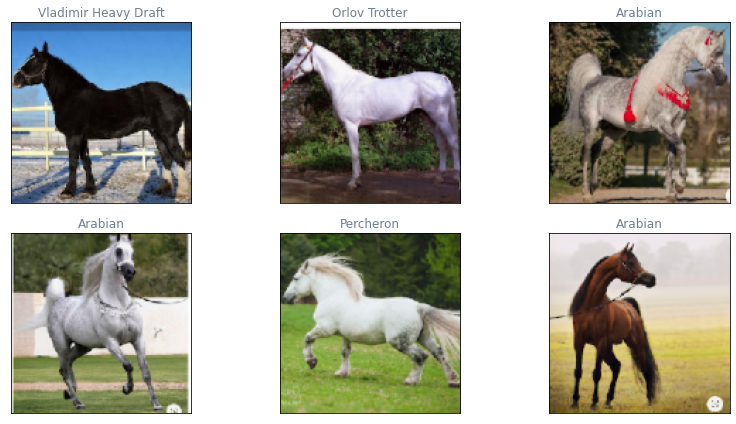

,train,valid,test
image shape,"(451, 128, 128, 3)","(56, 128, 128, 3)","(56, 128, 128, 3)"
image type,float32,float32,float32
label shape,"(451,)","(56,)","(56,)"
label type,int32,int32,int32


In [10]:
N=labels.shape[0]; n=int(.1*N)
num_classes=len(names); start=int(100) 
shuffle_ids=np.arange(N)
np.random.RandomState(12).shuffle(shuffle_ids)
images=images[shuffle_ids]; labels=labels[shuffle_ids]
x_test,x_valid,x_train=images[:n],images[n:2*n],images[2*n:]
y_test,y_valid,y_train=labels[:n],labels[n:2*n],labels[2*n:]
df=pd.DataFrame(
    [[x_train.shape,x_valid.shape,x_test.shape],
     [x_train.dtype,x_valid.dtype,x_test.dtype],
     [y_train.shape,y_valid.shape,y_test.shape],
     [y_train.dtype,y_valid.dtype,y_test.dtype]],
    columns=['train','valid','test'],
    index=['image shape','image type','label shape','label type'])
def display_imgs(images,labels,names,start):
    fig=pl.figure(figsize=(12,6)); n=np.random.randint(0,start-1)
    for i in range(n,n+6):
        ax=fig.add_subplot(2,3,i-n+1,xticks=[],yticks=[])
        ax.set_title(
            names[labels[i]],color='slategray',fontdict={'fontsize':'large'})
        ax.imshow((images[i]))
    pl.tight_layout(); pl.show()
display_imgs(images,labels,names,start); display(df)

## ✒️ Super Resolution

In [3]:
def esrgantf2_superresolution(img,img_size=int(50)):
    model=hub.load('https://tfhub.dev/captain-pool/esrgan-tf2/1')
    func=model.signatures[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
    func.inputs[int(0)].set_shape([int(1),img_size,img_size,int(3)])
    converter=tf.lite.TFLiteConverter.from_concrete_functions([func])
    converter.optimizations=[tf.lite.Optimize.DEFAULT]
    tflite_model=converter.convert()
    with tf.io.gfile.GFile('ESRGAN.tflite','wb') as f:
        f.write(tflite_model)
    esrgan_model_path='./ESRGAN.tflite'
    if img.mean()<float(1): img=img*float(255)
    lr=tf.image.resize(img,[img_size,img_size])
    lr=tf.expand_dims(lr.numpy()[:,:,:int(3)],axis=int(0))
    lr=tf.cast(lr,tf.float32)
    interpreter=tf.lite.Interpreter(model_path=esrgan_model_path)
    interpreter.allocate_tensors()
    input_details=interpreter.get_input_details()
    output_details=interpreter.get_output_details()
    interpreter.set_tensor(input_details[int(0)]['index'],lr)
    interpreter.invoke()
    output_data=interpreter.get_tensor(output_details[int(0)]['index'])
    sr=tf.squeeze(output_data,axis=int(0))
    sr=tf.clip_by_value(sr,int(0),int(255))
    sr=tf.round(sr); sr=tf.cast(sr,tf.uint8)
    lr=tf.cast(tf.squeeze(lr,axis=int(0)),tf.uint8)
    return lr,sr
lr,sr=esrgantf2_superresolution(images[int(0)],img_size)

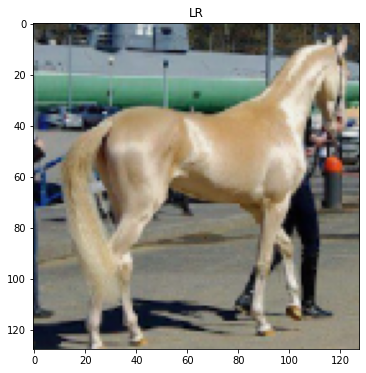

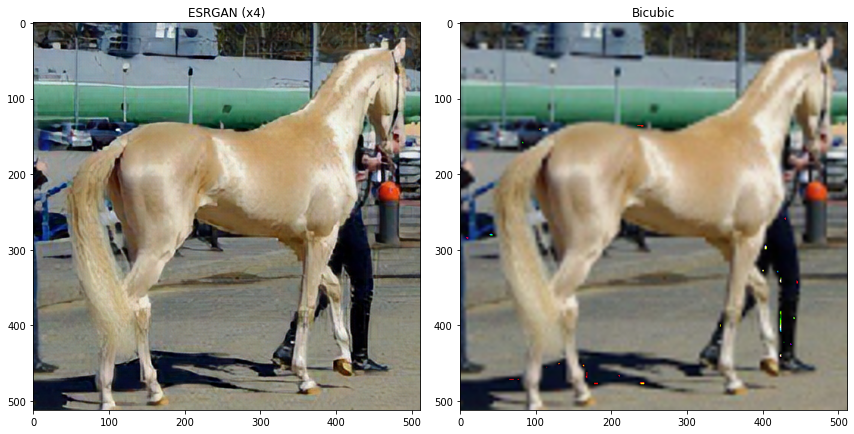

In [5]:
def low2superbicubic_imgs(lr,sr):
    pl.figure(figsize=(12,6)); pl.title('LR')
    pl.imshow(lr.numpy()); pl.show()
    pl.figure(figsize=(12,6))
    pl.subplot(1,2,1); pl.title(f'ESRGAN (x4)')
    pl.imshow(sr.numpy())
    img_size=lr.shape[int(1)]
    bicubic=tf.image.resize(
        lr,[img_size*int(4),img_size*int(4)],
        tf.image.ResizeMethod.BICUBIC)
    bicubic=tf.cast(bicubic, tf.uint8)
    pl.subplot(1,2,2); pl.title('Bicubic')
    pl.imshow(bicubic.numpy())
    pl.tight_layout(); pl.show()
low2superbicubic_imgs(lr,sr)